# Main Noteboook
this is the core notebook that soon to be implemented in src/

In [1]:
# CORE
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import pickle
import joblib
import torch

# VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns

# SCIKIT-LEARN PREPROCESSING
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize

# SCIKIT-LEARN MODEL SELECTION
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV

# SCIKIT-LEARN METRICS
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)
from sklearn.metrics.pairwise import cosine_similarity

# IMBALANCED-LEARN 
from imblearn.over_sampling import SMOTE

# MACHINE LEARNING MODELS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.decomposition import NMF

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# TENSORFLOW / KERAS
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Data Preprocessing
Pada data preprocessing ini tidak ada handling untuk missing values dan duplicates karena dataset yang disediakan tidak ada masalah tersebut

## Data Loading

In [2]:
# Load raw data
df = pd.read_csv('../data/raw/data_capstone.csv')
df.head()

,customer_id,plan_type,device_brand,avg_data_usage_gb,pct_video_usage,avg_call_duration,sms_freq,monthly_spend,topup_freq,travel_score,complaint_count,target_offer
0,C00001,Prepaid,Realme,1.50,0.804146,7.98,13,70000.0,4,0.284419,0,General Offer
1,C00002,Postpaid,Vivo,1.09,0.107686,9.56,9,63000.0,3,0.115086,0,General Offer
2,C00003,Postpaid,Xiaomi,3.24,0.313894,4.61,13,89000.0,7,0.402998,0,General Offer
3,C00004,Prepaid,Apple,5.32,0.420158,6.96,8,67000.0,4,0.302169,0,General Offer
4,C00005,Prepaid,Huawei,1.91,0.251638,11.01,21,72000.0,5,0.487911,0,General Offer


## Outlier Handling

### Visualize

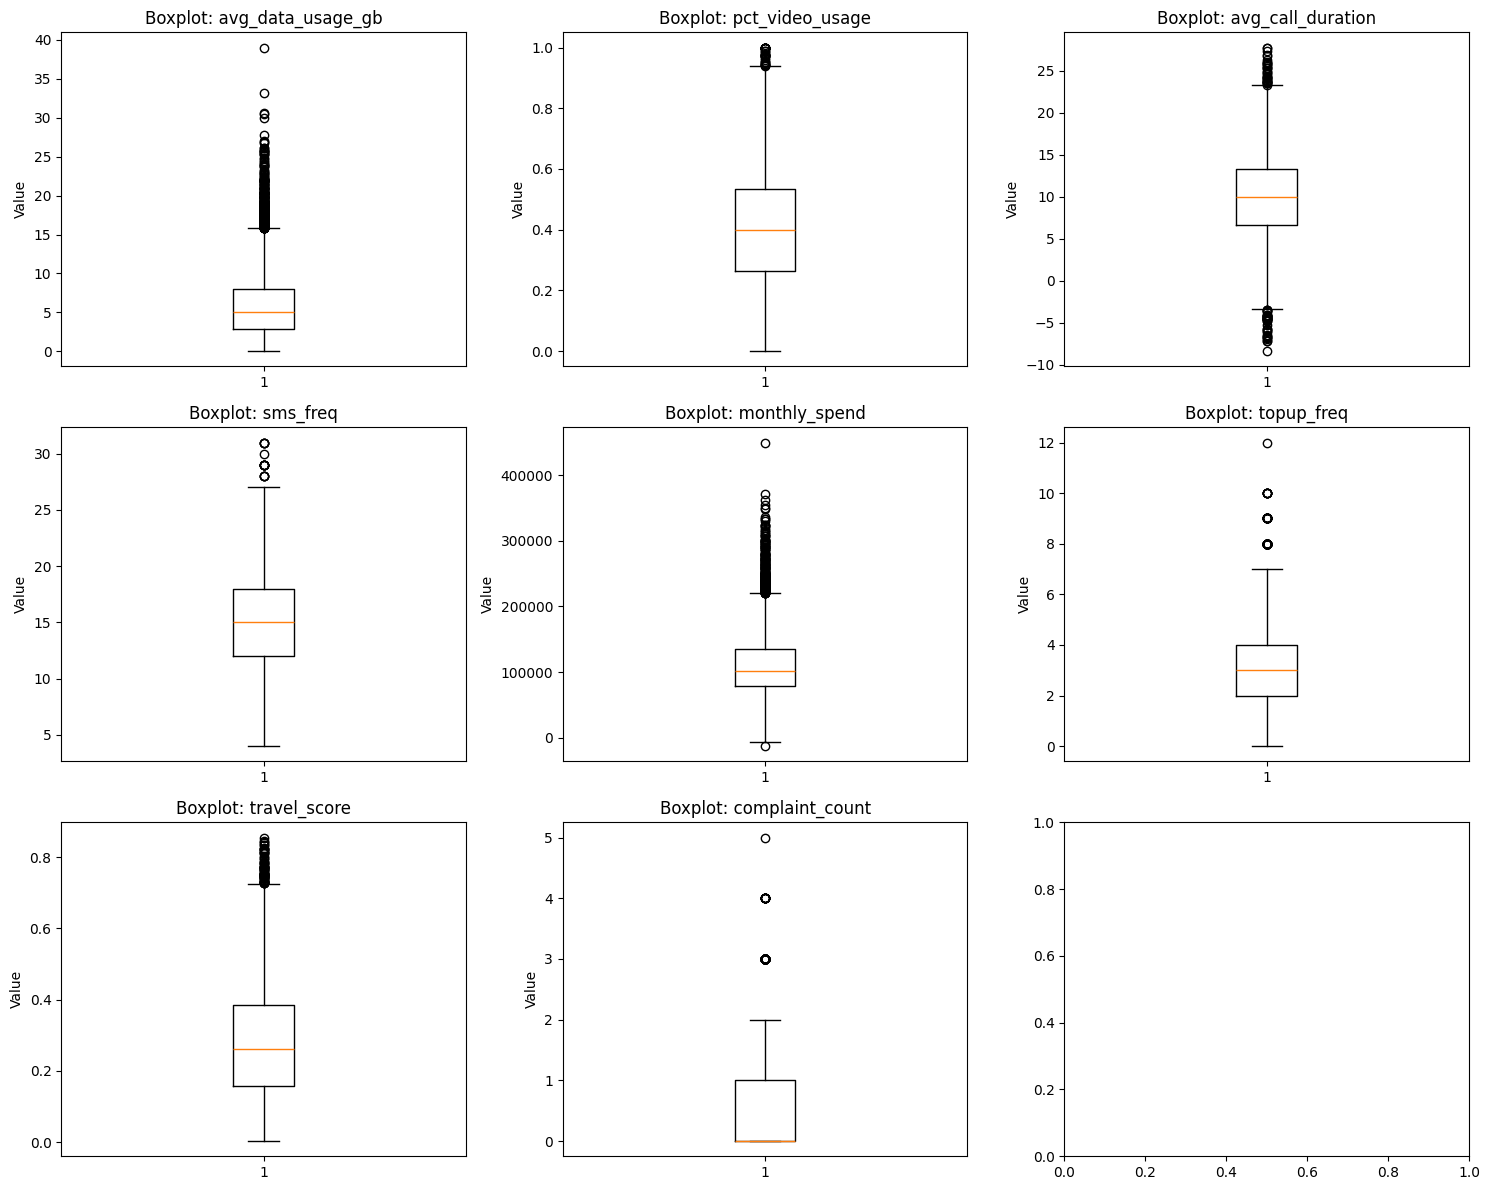

In [3]:
# Deteksi Outliers dengan IQR
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
# Visualisasi Outliers dengan Boxplot
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    if idx < len(axes):
        axes[idx].boxplot(df[col].dropna())
        axes[idx].set_title(f'Boxplot: {col}')
        axes[idx].set_ylabel('Value')

plt.tight_layout()
plt.show()

### Detecting

In [4]:
# Hapus kolom yang bukan fitur (seperti customer_id sudah object, jadi aman)
# Tapi hapus kolom target atau ID jika ada dalam numerical
print("DETEKSI OUTLIERS (IQR METHOD)")

outlier_info = {}
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_info[col] = len(outliers)
    
    print(f"\n{col}:")
    print(f"  Lower bound: {lower_bound:.2f}")
    print(f"  Upper bound: {upper_bound:.2f}")
    print(f"  Jumlah outliers: {len(outliers)}")

DETEKSI OUTLIERS (IQR METHOD)

avg_data_usage_gb:
  Lower bound: -4.88
  Upper bound: 15.79
  Jumlah outliers: 305

pct_video_usage:
  Lower bound: -0.14
  Upper bound: 0.94
  Jumlah outliers: 40

avg_call_duration:
  Lower bound: -3.35
  Upper bound: 23.32
  Jumlah outliers: 72

sms_freq:
  Lower bound: 3.00
  Upper bound: 27.00
  Jumlah outliers: 17

monthly_spend:
  Lower bound: -7500.00
  Upper bound: 220500.00
  Jumlah outliers: 250

topup_freq:
  Lower bound: -1.00
  Upper bound: 7.00
  Jumlah outliers: 110

travel_score:
  Lower bound: -0.18
  Upper bound: 0.73
  Jumlah outliers: 70

complaint_count:
  Lower bound: -1.50
  Upper bound: 2.50
  Jumlah outliers: 138


### Summary

In [5]:
print("\nSUMMARY OUTLIERS")
for col, count in outlier_info.items():
    if count > 0:
        print(f"{col}: {count} outliers ({count/len(df)*100:.2f}%)")


SUMMARY OUTLIERS
avg_data_usage_gb: 305 outliers (3.05%)
pct_video_usage: 40 outliers (0.40%)
avg_call_duration: 72 outliers (0.72%)
sms_freq: 17 outliers (0.17%)
monthly_spend: 250 outliers (2.50%)
topup_freq: 110 outliers (1.10%)
travel_score: 70 outliers (0.70%)
complaint_count: 138 outliers (1.38%)


### Remove the outlier

In [6]:
# # Strategy: Remove rows where any numeric column has outliers (based on IQR)
# # Create a mask for rows to keep (no outliers in any numeric column)
# mask = pd.Series([True] * len(df))
# for col in numerical_cols:
#     Q1 = df[col].quantile(0.25)
#     Q3 = df[col].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     mask &= (df[col] >= lower_bound) & (df[col] <= upper_bound)

# df_before_outlier_handling = df.copy()
# df = df[mask].copy()

# print(f"Rows before outlier handling: {len(df_before_outlier_handling)}")
# print(f"Rows after outlier handling: {len(df)}")
# print(f"Rows removed: {len(df_before_outlier_handling) - len(df)}")

### Visualization the Before and After removing the outlier

In [7]:

    # # Visualize Before and After Outlier Handling
    # fig, axes = plt.subplots(2, len(numerical_cols), figsize=(20, 10))

    # for idx, col in enumerate(numerical_cols):
    #     # Before
    #     axes[0, idx].boxplot(df_before_outlier_handling[col].dropna())
    #     axes[0, idx].set_title(f'Before: {col}')
    #     axes[0, idx].set_ylabel('Value')
        
    #     # After
    #     axes[1, idx].boxplot(df[col].dropna())
    #     axes[1, idx].set_title(f'After: {col}')
    #     axes[1, idx].set_ylabel('Value')

    # plt.tight_layout()
    # plt.show()

### Remove Negative Values

In [8]:
# Remove negative numeric values (drop rows where any numeric column < 0)

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
neg_counts = (df[num_cols] < 0).sum()
print("Negative value counts per numeric column:")
print(neg_counts[neg_counts > 0])

# Hitung berapa baris yang memiliki nilai negatif di kolom numerik apapun
rows_with_neg = df[(df[num_cols] < 0).any(axis=1)].shape[0]
print(f"\nTotal baris dengan setidaknya satu nilai numeric negatif: {rows_with_neg}")

if rows_with_neg > 0:
    df_before = len(df)
    # Drop rows that have any negative numeric value
    df = df[~(df[num_cols] < 0).any(axis=1)].copy()
    df_after = len(df)
    print(f"Baris sebelum: {df_before}; baris sesudah: {df_after}; terhapus: {df_before - df_after}")
else:
    print("Tidak ditemukan nilai numeric negatif — tidak ada perubahan pada dataframe")


Negative value counts per numeric column:
avg_call_duration    229
monthly_spend          2
dtype: int64

Total baris dengan setidaknya satu nilai numeric negatif: 231
Baris sebelum: 10000; baris sesudah: 9769; terhapus: 231


## Feature Importance

THe reason for dropping sms_freq and avg_call_duration is connected to EDA where both of these feature actually useless compared to other, here is the output using decision tree with 6 depth:  
| Rank | Feature             | Importance |
|------|---------------------|------------|
| 1    | monthly_spend       | 0.274486   |
| 2    | complaint_count     | 0.177292   |
| 3    | device_brand        | 0.170882   |
| 4    | pct_video_usage     | 0.138131   |
| 5    | avg_data_usage_gb   | 0.130795   |
| 6    | plan_type           | 0.041409   |
| 7    | topup_freq          | 0.028904   |
| 8    | travel_score        | 0.027488   |
| 9    | avg_call_duration   | 0.007678   |
| 10   | sms_freq            | 0.002934   |


As you can see that the gap is huge between the third last and the second last, so we considering to drop them, and ofcourse excluding ID and target

In [9]:
# # Drop fitur yang dikecualikan dari modeling

# excluded_features = ['sms_freq', 'avg_call_duration']

# df_before_drop = df.shape[1]
# df = df.drop(columns=excluded_features, errors='ignore')
# df_after_drop = df.shape[1]

# print(f"\nJumlah kolom sebelum: {df_before_drop}")
# print(f"Jumlah kolom sesudah: {df_after_drop}")
# print(f"Kolom terhapus: {df_before_drop - df_after_drop}")
# print(f"\nKolom yang tersisa:")
# display(df.columns.tolist())

## Encoding

### Memisahkan feature & Target


In [10]:
# Simpan customer_id dan target sebelum encoding
customer_ids = df['customer_id'].copy()
target = df['target_offer'].copy()

# Drop kolom yang tidak perlu untuk modeling
df_encoded = df.drop(['customer_id', 'target_offer'], axis=1)

print("Kolom kategorikal yang akan di-encode:")
categorical_cols = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
for col in categorical_cols:
    print(f"  - {col}: {df_encoded[col].nunique()} unique values")

Kolom kategorikal yang akan di-encode:
  - plan_type: 2 unique values
  - device_brand: 7 unique values


### Label Encoding untuk target variable

In [11]:
le_target = LabelEncoder()
target_encoded = le_target.fit_transform(target)

print("\nTarget encoding:")
print(f"Classes: {le_target.classes_}")
print(f"Encoded values: {np.unique(target_encoded)}")

# Simpan mapping untuk interpretasi nanti
target_mapping = dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))
print(f"\nTarget mapping: {target_mapping}")


Target encoding:
Classes: ['Data Booster' 'Device Upgrade Offer' 'Family Plan Offer' 'General Offer'
 'Retention Offer' 'Roaming Pass' 'Streaming Partner Pack' 'Top-up Promo'
 'Voice Bundle']
Encoded values: [0 1 2 3 4 5 6 7 8]

Target mapping: {'Data Booster': np.int64(0), 'Device Upgrade Offer': np.int64(1), 'Family Plan Offer': np.int64(2), 'General Offer': np.int64(3), 'Retention Offer': np.int64(4), 'Roaming Pass': np.int64(5), 'Streaming Partner Pack': np.int64(6), 'Top-up Promo': np.int64(7), 'Voice Bundle': np.int64(8)}


### Encoding Process

In [12]:
# One-Hot Encoding untuk features kategorikal
# Untuk kolom dengan cardinalitas rendah gunakan One-Hot
# Untuk kolom dengan cardinalitas tinggi gunakan Label Encoding atau Target Encoding

df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True)

print(f"Shape setelah encoding: {df_encoded.shape}")
print(f"Total features setelah encoding: {df_encoded.shape[1]}")

Shape setelah encoding: (9769, 15)
Total features setelah encoding: 15


## Normalization (Scalling)

In [13]:
# Initialize scaler
scaler = StandardScaler()

# Fit dan transform pada features
X_scaled = scaler.fit_transform(df_encoded)

# Convert kembali ke DataFrame untuk kemudahan
df_scaled = pd.DataFrame(X_scaled, columns=df_encoded.columns, index=df_encoded.index)

print(f"Shape data setelah scaling: {df_scaled.shape}")
print("\nStatistik setelah scaling (sampel 5 kolom pertama):")
print(df_scaled.iloc[:, :5].describe())

Shape data setelah scaling: (9769, 15)

Statistik setelah scaling (sampel 5 kolom pertama):
       avg_data_usage_gb  pct_video_usage  avg_call_duration      sms_freq  \
count       9.769000e+03     9.769000e+03       9.769000e+03  9.769000e+03   
mean        7.200709e-17    -6.982506e-17       3.862199e-16 -1.680166e-16   
std         1.000051e+00     1.000051e+00       1.000051e+00  1.000051e+00   
min        -1.411574e+00    -2.056754e+00      -2.196753e+00 -2.841904e+00   
25%        -7.354749e-01    -6.997001e-01      -7.139518e-01 -7.793642e-01   
50%        -2.307809e-01    -1.426783e-02      -1.654164e-02 -5.911672e-03   
75%         4.929312e-01     6.771231e-01       6.744309e-01  7.675408e-01   
max         7.870509e+00     3.046142e+00       3.760203e+00  4.119168e+00   

       monthly_spend  
count   9.769000e+03  
mean   -7.018873e-17  
std     1.000051e+00  
min    -2.328658e+00  
25%    -6.878312e-01  
50%    -1.696754e-01  
75%     5.427889e-01  
max     7.343584e+00 

## Data Split

### Split 80/20

In [14]:
# Split dengan stratified untuk menjaga proporsi target
X_train, X_test, y_train, y_test = train_test_split(
    df_scaled, 
    target_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=target_encoded
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print(f"\nProporsi split:")
print(f"  Training: {len(X_train)/len(df_scaled)*100:.1f}%")
print(f"  Testing: {len(X_test)/len(df_scaled)*100:.1f}%")

# Cek distribusi target di train dan test
print(f"\nDistribusi target di training set:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Class {u}: {c} ({c/len(y_train)*100:.1f}%)")

print(f"\nDistribusi target di testing set:")
unique, counts = np.unique(y_test, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Class {u}: {c} ({c/len(y_test)*100:.1f}%)")

X_train shape: (7815, 15)
X_test shape: (1954, 15)
y_train shape: (7815,)
y_test shape: (1954,)

Proporsi split:
  Training: 80.0%
  Testing: 20.0%

Distribusi target di training set:
  Class 0: 626 (8.0%)
  Class 1: 1171 (15.0%)
  Class 2: 62 (0.8%)
  Class 3: 4741 (60.7%)
  Class 4: 594 (7.6%)
  Class 5: 74 (0.9%)
  Class 6: 202 (2.6%)
  Class 7: 290 (3.7%)
  Class 8: 55 (0.7%)

Distribusi target di testing set:
  Class 0: 157 (8.0%)
  Class 1: 293 (15.0%)
  Class 2: 16 (0.8%)
  Class 3: 1185 (60.6%)
  Class 4: 148 (7.6%)
  Class 5: 18 (0.9%)
  Class 6: 51 (2.6%)
  Class 7: 73 (3.7%)
  Class 8: 13 (0.7%)


### Handle Imbalanced Data dengan SMOTE 
**PENTING:** Data memiliki imbalance ratio 89:1 (General Offer vs Voice Bundle)  
SMOTE akan membuat synthetic samples untuk kelas minoritas agar model tidak bias

In [15]:
# Cek distribusi sebelum SMOTE
print("\n DISTRIBUSI SEBELUM SMOTE:")
print("Training set:")
unique, counts = np.unique(y_train, return_counts=True)
for u, c in zip(unique, counts):
    class_name = le_target.classes_[u]
    print(f"  {class_name}: {c:,} ({c/len(y_train)*100:.1f}%)")

print(f"\nTotal training samples: {len(y_train):,}")


 DISTRIBUSI SEBELUM SMOTE:
Training set:
  Data Booster: 626 (8.0%)
  Device Upgrade Offer: 1,171 (15.0%)
  Family Plan Offer: 62 (0.8%)
  General Offer: 4,741 (60.7%)
  Retention Offer: 594 (7.6%)
  Roaming Pass: 74 (0.9%)
  Streaming Partner Pack: 202 (2.6%)
  Top-up Promo: 290 (3.7%)
  Voice Bundle: 55 (0.7%)

Total training samples: 7,815


In [16]:
# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Cek distribusi setelah SMOTE
print("\n DISTRIBUSI SETELAH SMOTE:")
print("Training set (balanced):")
unique, counts = np.unique(y_train_balanced, return_counts=True)
for u, c in zip(unique, counts):
    class_name = le_target.classes_[u]
    print(f"  {class_name}: {c:,} ({c/len(y_train_balanced)*100:.1f}%)")

print(f"\nTotal training samples setelah SMOTE: {len(y_train_balanced):,}")
print(f"Penambahan data: {len(y_train_balanced) - len(y_train):,} samples")
print(f"\n Test set TIDAK diubah (tetap {len(y_test):,} samples)")



 DISTRIBUSI SETELAH SMOTE:
Training set (balanced):
  Data Booster: 4,741 (11.1%)
  Device Upgrade Offer: 4,741 (11.1%)
  Family Plan Offer: 4,741 (11.1%)
  General Offer: 4,741 (11.1%)
  Retention Offer: 4,741 (11.1%)
  Roaming Pass: 4,741 (11.1%)
  Streaming Partner Pack: 4,741 (11.1%)
  Top-up Promo: 4,741 (11.1%)
  Voice Bundle: 4,741 (11.1%)

Total training samples setelah SMOTE: 42,669
Penambahan data: 34,854 samples

 Test set TIDAK diubah (tetap 1,954 samples)


### Visualization comparison

✓ Visualisasi disimpan ke: ../data/plot/smote_comparison.png


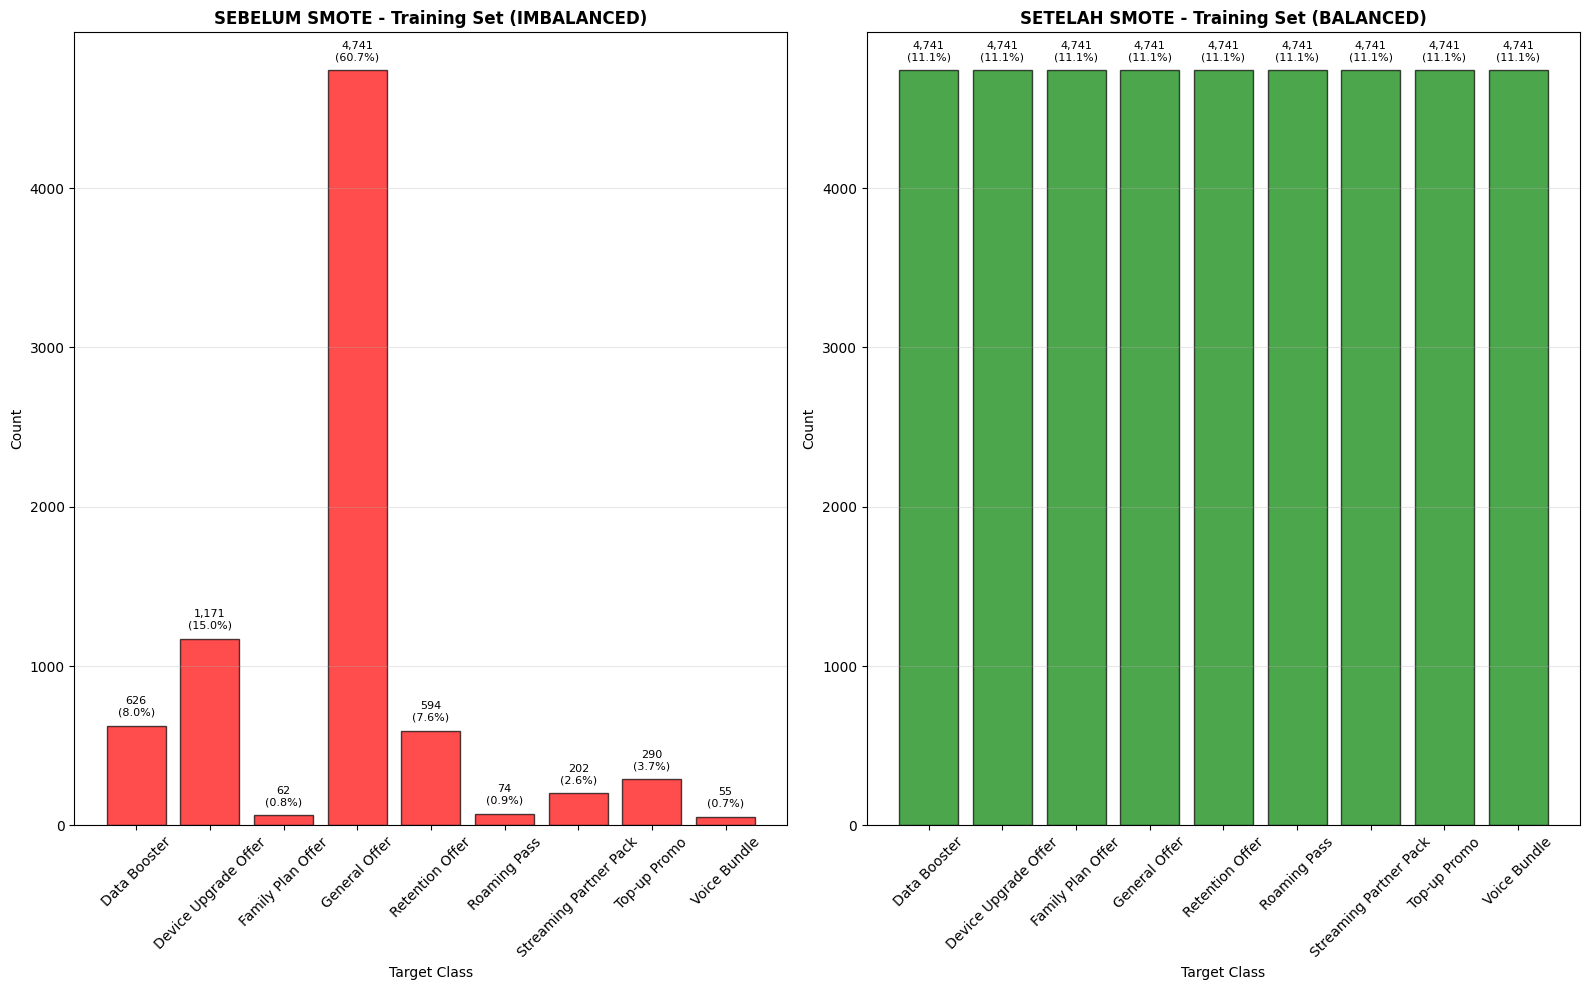

In [17]:
# Visualisasi distribusi sebelum dan sesudah SMOTE
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Before SMOTE
unique_before, counts_before = np.unique(y_train, return_counts=True)
class_names = [le_target.classes_[u] for u in unique_before]
axes[0].bar(class_names, counts_before, edgecolor='black', alpha=0.7, color='red')
axes[0].set_title('SEBELUM SMOTE - Training Set (IMBALANCED)', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Target Class')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(counts_before):
    axes[0].text(i, v + 50, f'{v:,}\n({v/len(y_train)*100:.1f}%)', ha='center', va='bottom', fontsize=8)

# After SMOTE
unique_after, counts_after = np.unique(y_train_balanced, return_counts=True)
class_names = [le_target.classes_[u] for u in unique_after]
axes[1].bar(class_names, counts_after, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('SETELAH SMOTE - Training Set (BALANCED)', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Target Class')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(counts_after):
    axes[1].text(i, v + 50, f'{v:,}\n({v/len(y_train_balanced)*100:.1f}%)', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('../data/plot/smote_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Visualisasi disimpan ke: ../data/plot/smote_comparison.png")
plt.show()

## Save the processed data

In [18]:
# Save original training data (before SMOTE)
np.save('../data/processed/X_train_original.npy', X_train)
np.save('../data/processed/y_train_original.npy', y_train)

# Save balanced training data (after SMOTE)
np.save('../data/processed/X_train.npy', X_train_balanced)
np.save('../data/processed/y_train.npy', y_train_balanced)


print(" Saving original test data...")
np.save('../data/processed/X_test.npy', X_test)
np.save('../data/processed/y_test.npy', y_test)

# Save scaler dan encoder untuk production use
with open('../data/processed/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('../data/processed/label_encoder.pkl', 'wb') as f:
    pickle.dump(le_target, f)

# Save feature names
with open('../data/processed/feature_names.pkl', 'wb') as f:
    pickle.dump(df_scaled.columns.tolist(), f)

# Save target mapping
with open('../data/processed/target_mapping.pkl', 'wb') as f:
    pickle.dump(target_mapping, f)

# Save processed dataframe lengkap (optional)
df_final = df_scaled.copy()
df_final['target'] = target_encoded
df_final.to_csv('../data/processed/processed_data.csv', index=False)
print(f"\n Training set size: {len(y_train_balanced):,} (setelah SMOTE)")
print(f" Test set size: {len(y_test):,} (data original)")

 Saving original test data...

 Training set size: 42,669 (setelah SMOTE)
 Test set size: 1,954 (data original)


# **JUMP HERE FOR TESTING**

# MODELING

## Data Loading

**PENTING** : 
Run this if you jump to this section

In [19]:
# Load original training data (before SMOTE)
X_train = np.load('../data/processed/X_train_original.npy')
y_train = np.load('../data/processed/y_train_original.npy')

# Load balanced training data (after SMOTE)
X_train_balanced = np.load('../data/processed/X_train.npy')
y_train_balanced = np.load('../data/processed/y_train.npy')

# Load testing data (original)
X_test = np.load('../data/processed/X_test.npy')
y_test = np.load('../data/processed/y_test.npy')

# Load artifacts
with open('../data/processed/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('../data/processed/label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

with open('../data/processed/feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

print(f"Original training samples: {len(y_train):,}")
print(f"Balanced training samples: {len(y_train_balanced):,}")
print(f"Testing samples: {len(y_test):,}")
print(f"Features: {len(feature_names)}")

Original training samples: 7,815
Balanced training samples: 42,669
Testing samples: 1,954
Features: 15


In [20]:
# XGBoost on original (unbalanced) data
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(np.unique(y_train)),
    random_state=42,
    n_estimators=200,  
    max_depth=10,       
    learning_rate=0.1,
)


xgb_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)

print("XGBoost on data unbalanced")
print("F1-Weighted:", f1_score(y_test, y_pred_xgb, average='weighted'))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

try:
    auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb, multi_class='ovr')
    print(f"ROC-AUC (ovr): {auc_xgb:.4f}")
except:
    print("ROC-AUC not available.")

XGBoost on data unbalanced
F1-Weighted: 0.9928374532525301

Classification Report:
                        precision    recall  f1-score   support

          Data Booster       0.98      0.99      0.98       157
  Device Upgrade Offer       0.99      0.99      0.99       293
     Family Plan Offer       1.00      0.94      0.97        16
         General Offer       1.00      0.99      1.00      1185
       Retention Offer       0.97      0.99      0.98       148
          Roaming Pass       0.94      0.89      0.91        18
Streaming Partner Pack       0.96      1.00      0.98        51
          Top-up Promo       1.00      1.00      1.00        73
          Voice Bundle       0.93      1.00      0.96        13

              accuracy                           0.99      1954
             macro avg       0.98      0.98      0.98      1954
          weighted avg       0.99      0.99      0.99      1954


Confusion Matrix:
[[ 155    2    0    0    0    0    0    0    0]
 [   2  291    

In [21]:
# LightGBM on balanced data
lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(np.unique(y_train_balanced)),
    random_state=42,
    n_estimators=200,
    max_depth=10,
    learning_rate=0.05
)

lgb_model.fit(X_train_balanced, y_train_balanced)
y_pred_lgb = lgb_model.predict(X_test)
print(f"LightGBM Macro F1: {f1_score(y_test, y_pred_lgb, average='macro'):.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001907 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 42669, number of used features: 15
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

In [22]:
# Random Forest on balanced data
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    random_state=42,
    class_weight='balanced'  # Additional balancing
)

rf_model.fit(X_train_balanced, y_train_balanced)

# Predictions and evaluation
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)

print("Random Forest on Balanced Data")
print("F1-Weighted:", f1_score(y_test, y_pred_rf, average='weighted'))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

try:
    auc_rf = roc_auc_score(y_test, y_pred_proba_rf, multi_class='ovr')
    print(f"ROC-AUC (ovr): {auc_rf:.4f}")
except:
    print("ROC-AUC not available.")

Random Forest on Balanced Data
F1-Weighted: 0.7730631355271849

Classification Report:
                        precision    recall  f1-score   support

          Data Booster       0.97      0.92      0.94       157
  Device Upgrade Offer       0.57      0.83      0.67       293
     Family Plan Offer       0.25      1.00      0.40        16
         General Offer       0.99      0.65      0.79      1185
       Retention Offer       0.80      0.95      0.87       148
          Roaming Pass       0.85      0.94      0.89        18
Streaming Partner Pack       0.27      0.96      0.43        51
          Top-up Promo       0.52      0.97      0.68        73
          Voice Bundle       0.63      0.92      0.75        13

              accuracy                           0.75      1954
             macro avg       0.65      0.91      0.71      1954
          weighted avg       0.87      0.75      0.77      1954


Confusion Matrix:
[[144   3   5   0   2   3   0   0   0]
 [  2 243  13   3  1

In [23]:
# Gradient Boosting on balanced data
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_balanced)

# Gradient Boosting on balanced data with sample weights
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

gb_model.fit(X_train_balanced, y_train_balanced, sample_weight=sample_weights)

# Predictions and evaluation
y_pred_gb = gb_model.predict(X_test)
y_pred_proba_gb = gb_model.predict_proba(X_test)

print("Gradient Boosting on Balanced Data")
print("F1-Weighted:", f1_score(y_test, y_pred_gb, average='weighted'))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb, target_names=label_encoder.classes_))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_gb))

try:
    auc_gb = roc_auc_score(y_test, y_pred_proba_gb, multi_class='ovr')
    print(f"ROC-AUC (ovr): {auc_gb:.4f}")
except:
    print("ROC-AUC not available.")

Gradient Boosting on Balanced Data
F1-Weighted: 0.9969281180121613

Classification Report:
                        precision    recall  f1-score   support

          Data Booster       1.00      0.98      0.99       157
  Device Upgrade Offer       1.00      1.00      1.00       293
     Family Plan Offer       1.00      0.94      0.97        16
         General Offer       1.00      1.00      1.00      1185
       Retention Offer       0.99      1.00      1.00       148
          Roaming Pass       0.89      0.94      0.92        18
Streaming Partner Pack       0.98      1.00      0.99        51
          Top-up Promo       1.00      1.00      1.00        73
          Voice Bundle       1.00      0.92      0.96        13

              accuracy                           1.00      1954
             macro avg       0.98      0.98      0.98      1954
          weighted avg       1.00      1.00      1.00      1954


Confusion Matrix:
[[ 154    0    0    0    1    2    0    0    0]
 [   0 

In [24]:
# CatBoost on balanced data
cb_model = CatBoostClassifier(
    iterations=600,         
    learning_rate=0.1,
    depth=6,              
    loss_function="MultiClass",
    eval_metric="TotalF1",
    random_seed=42,
    grow_policy="Depthwise",
    early_stopping_rounds=40,
    l2_leaf_reg=5,
    random_strength=1.2,
    colsample_bylevel=0.8,
)
cb_model.fit(X_train_balanced, y_train_balanced)

# Predictions and evaluation
y_pred_cb = cb_model.predict(X_test)
y_pred_proba_cb = cb_model.predict_proba(X_test)

print("CatBoost on Balanced Data")
print("F1-Weighted:", f1_score(y_test, y_pred_cb, average='weighted'))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_cb, target_names=label_encoder.classes_))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_cb))

try:
    auc_cb = roc_auc_score(y_test, y_pred_proba_cb, multi_class='ovr')
    print(f"ROC-AUC (ovr): {auc_cb:.4f}")
except:
    print("ROC-AUC not available.")

0:	learn: 0.8070372	total: 89.8ms	remaining: 53.8s
1:	learn: 0.8902467	total: 120ms	remaining: 35.9s
2:	learn: 0.9148900	total: 150ms	remaining: 29.8s
3:	learn: 0.9374552	total: 177ms	remaining: 26.4s
4:	learn: 0.9391444	total: 206ms	remaining: 24.5s
5:	learn: 0.9420620	total: 233ms	remaining: 23.1s
6:	learn: 0.9465651	total: 259ms	remaining: 22s
7:	learn: 0.9487436	total: 286ms	remaining: 21.1s
8:	learn: 0.9511274	total: 312ms	remaining: 20.5s
9:	learn: 0.9535855	total: 343ms	remaining: 20.2s
10:	learn: 0.9558770	total: 371ms	remaining: 19.9s
11:	learn: 0.9635627	total: 398ms	remaining: 19.5s
12:	learn: 0.9657075	total: 425ms	remaining: 19.2s
13:	learn: 0.9676454	total: 451ms	remaining: 18.9s
14:	learn: 0.9728333	total: 478ms	remaining: 18.6s
15:	learn: 0.9736930	total: 504ms	remaining: 18.4s
16:	learn: 0.9742850	total: 529ms	remaining: 18.1s
17:	learn: 0.9752712	total: 556ms	remaining: 18s
18:	learn: 0.9756584	total: 581ms	remaining: 17.8s
19:	learn: 0.9767208	total: 607ms	remaining:

In [27]:
# Summary of results
print("\n SUMMARY OF F1 SCORES ")
print(f"XGBoost on data unbalanced F1-Weighted: {f1_score(y_test, y_pred_xgb, average='weighted'):.4f}")
print("lightGBM F1-Weighted:", f1_score(y_test, y_pred_lgb, average='weighted'))
print(f"Random Forest F1-Weighted: {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"Gradient Boosting F1-Weighted: {f1_score(y_test, y_pred_gb, average='weighted'):.4f}")
print(f"CatBoost F1-Weighted: {f1_score(y_test, y_pred_cb, average='weighted'):.4f}")

print("\n MACRO F1 SCORES ")
print(f"XGBoost on data unbalanced F1-macro: {f1_score(y_test, y_pred_xgb, average='macro'):.4f}")
print("lightGBM F1-macro:", f1_score(y_test, y_pred_lgb, average='macro'))
print(f"Random Forest F1-macro: {f1_score(y_test, y_pred_rf, average='macro'):.4f}")
print(f"Gradient Boosting F1-macro: {f1_score(y_test, y_pred_gb, average='macro'):.4f}")
print(f"CatBoost F1-macro: {f1_score(y_test, y_pred_cb, average='macro'):.4f}")

print("\n SUMMARY OF ROC-AUC SCORES ")
print(f"XGBoost ROC-AUC: {auc_xgb:.4f}")
print(f"Random Forest ROC-AUC: {auc_rf:.4f}")
print(f"Gradient Boosting ROC-AUC: {auc_gb:.4f}")
print(f"CatBoost ROC-AUC: {auc_cb:.4f}")
# Add more metrics if needed, e.g., accuracy


 SUMMARY OF F1 SCORES 
XGBoost on data unbalanced F1-Weighted: 0.9928
lightGBM F1-Weighted: 0.9933491185392078
Random Forest F1-Weighted: 0.7731
Gradient Boosting F1-Weighted: 0.9969
CatBoost F1-Weighted: 0.9949

 MACRO F1 SCORES 
XGBoost on data unbalanced F1-macro: 0.9759
lightGBM F1-macro: 0.9784849650701593
Random Forest F1-macro: 0.7130
Gradient Boosting F1-macro: 0.9802
CatBoost F1-macro: 0.9840

 SUMMARY OF ROC-AUC SCORES 
XGBoost ROC-AUC: 0.9999
Random Forest ROC-AUC: 0.9910
Gradient Boosting ROC-AUC: 1.0000
CatBoost ROC-AUC: 1.0000
